In [33]:
!pip install Pyro-ppl
!pip3 install arviz

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyro
from pyro import distributions as dist
from pyro.contrib import gp
from torch.distributions import constraints
import arviz

Warmup:   0%|          | 0/2500 [01:56, ?it/s]


Data generation

In [3]:
def g(x):
  return (-(np.sin(6 * np.pi * x))**2 + 6 * x**2 - 5 * x**4 + 3/2)

In [4]:
def gen_data(l):
  x = np.zeros(l)
  for i in range(l):
    x[i] = i / (l-1)

  epsilon = np.random.normal(0, 0.01, l)
  y = g(x) + epsilon

  return x, y

In [5]:
l = 30
x, y = gen_data(l)
print(x.shape)
print(y.shape)

(30,)
(30,)


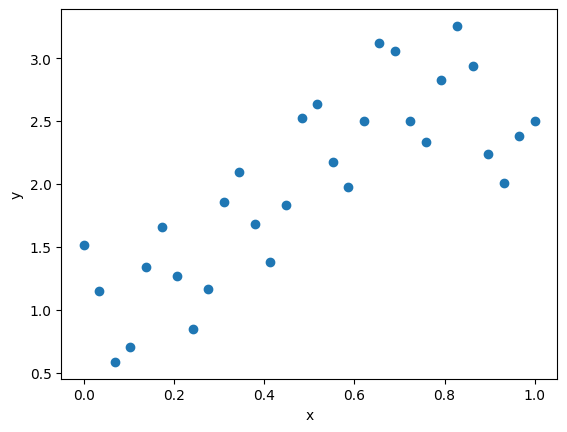

In [9]:
# plot x and y data
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [10]:
# partitioning
eval_indx = np.random.choice(l, 10, replace=False)
x_test, y_test = x[eval_indx], y[eval_indx]
x_train, y_train = np.delete(x, eval_indx), np.delete(y, eval_indx)

B.1 Fitting a standard GP

In [6]:
def gpr_model(X, Y):
    input_dim = 1#X.shape[0]

    #cos_kernel = gp.kernels.Cosine(input_dim = input_dim)
    periodic_kernel = gp.kernels.Periodic(input_dim = input_dim)
    #prod_kernel = gp.kernels.Product(cos_kernel, cos_kernel)
    poly2_kernel = gp.kernels.Polynomial(input_dim = input_dim, degree = 2)
    poly4_kernel = gp.kernels.Polynomial(input_dim = input_dim, degree = 4)
    sum_kernel_poly = gp.kernels.Sum(poly2_kernel, poly4_kernel)
    sum_kernel = gp.kernels.Sum(periodic_kernel, sum_kernel_poly)
    const_kernel = gp.kernels.Constant(input_dim = input_dim, variance = torch.Tensor([3/2]))

    kernel = gp.kernels.Sum(sum_kernel, const_kernel)

    # we pick a "high" variance according to Oswins notes page 16, "Weak priors"
    # further we pick 0 as mean because we have very little data (also page 16, "complexity arguments")

    periodic_kernel.variance = pyro.param(
        "variance_map",
        dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0)),  # samples initial value
        constraint=constraints.positive
    )
    #pyro.nn.PyroSample(dist.Normal(torch.tensor(0.0), torch.tensor(2.0))) # also try greater than 10^-4 gp lecture slide 52
    # lognormal restricting it to positive values
    periodic_kernel.lengthscale = pyro.param(
        "lengthscale_map",
        dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0)),  # samples initial value
        constraint=constraints.positive
    )
    periodic_kernel.period = pyro.param(
        "period_map",
        dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0)),  # samples initial value
        constraint=constraints.positive
    )
    poly2_kernel.variance = pyro.param(
        "variance_map",
        dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0)),  # samples initial value
        constraint=constraints.positive
    )

    poly4_kernel.variance = pyro.param(
        "variance_map",
        dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0)),  # samples initial value
        constraint=constraints.positive
    )

    gpr = gp.models.GPRegression(
                                  X=torch.tensor(X),
                                  y=torch.tensor(Y),
                                  kernel=kernel # noise=torch.tensor(0.1)
                                )

    return gpr

In [7]:
def LogLikelihood(x, y, params, model):
    x = torch.tensor(x)
    y = torch.tensor(y)
    noise_y = params[0]
    eta = params[1:]

    pyro.clear_param_store()

    # set kernel parameters
    # periodic kernels
    model.kernel.kern0.kern0.variance = eta[0]
    model.kernel.kern0.kern0.lengthscale = eta[1]
    model.kernel.kern0.kern0.period = eta[2]
    # polynomial kernels
    # d=2
    model.kernel.kern0.kern1.kern0.variance = eta[3]
    # d=4
    model.kernel.kern0.kern1.kern1.variance = eta[4]

    # run data trough kernel to compute covariance matrix
    cov_matrix = model.kernel(x)

    # log likelihood
    log_likelihood_first =  1/2 * y.T @ torch.linalg.inv(noise_y * torch.eye(len(x)) + cov_matrix) @ y
    log_likelihood_second =  1/2 * torch.log(torch.linalg.det(noise_y * torch.eye(len(x)) + cov_matrix))
    log_likelihood_third =  len(x)/2 * torch.log(torch.sqrt(2*torch.tensor(np.pi)))
    log_likelihood = - log_likelihood_first - log_likelihood_second - log_likelihood_third
    return log_likelihood

def prior_prob(params):
    eta = params[1:]

    # parameter values
    per_variance = eta[0].clone().detach()
    per_lengthscale = eta[1].clone().detach()
    per_period = eta[2].clone().detach()
    poly2_variance = eta[3].clone().detach()
    poly4_variance = eta[4].clone().detach()

    # priors
    per_var_prior = dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0))
    per_len_prior = dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0))
    per_period_prior = dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0))
    poly2_prior = dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0))
    poly4_prior = dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0))

    # log P(theta)
    log_prior = per_var_prior.log_prob(per_variance) + per_len_prior.log_prob(per_lengthscale) + per_period_prior.log_prob(per_period) + poly2_prior.log_prob(poly2_variance) + poly4_prior.log_prob(poly4_variance)
    return log_prior


def log_likelihood_y_theta(x, y, params):
    # clear parameters to create new model
    pyro.clear_param_store()

    # Define the model
    gpr = gpr_model(x, y)

    # log P(y|X, theta)
    ll = LogLikelihood(x, y, params, gpr)
    # log P(theta)
    prior = prior_prob(params)

    # P(y, theta|x) = P(y|X, theta) * P(theta)
    # log P(y, theta|x) = log P(y|X, theta) + log P(theta)
    return ll + prior

In [43]:
# Test with random parameters
log_likelihood_y_theta(x_train, y_train, torch.tensor([0.1542072296142578, 0.4293111264705658, 0.6498372554779053, 5.440501689910889, 0.0671844556927681, 0.03483118861913681]))

tensor(-12.0028, dtype=torch.float64, grad_fn=<AddBackward0>)

In [44]:
def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text

In [45]:
# maximum a-posteriori estimate θ∗
def MAP(x, y):
    # clear parameters to create new model
    pyro.clear_param_store()

    # Define the model
    gpr = gpr_model(x, y)

    # Printing for testing
    #for name, param in gpr.named_parameters():
    #    print(name, param)

    # Disable gradients for fixed parameters
    for param in gpr.parameters():
        param.requires_grad = False

    # Enable gradient for variable parameters
    gpr.noise_unconstrained.requires_grad = True
    gpr.kernel.kern0.kern0.variance_unconstrained.requires_grad = True                # per_kernel variance
    gpr.kernel.kern0.kern0.lengthscale_unconstrained.requires_grad = True             # per_kernel lengthscale
    gpr.kernel.kern0.kern0.period_unconstrained.requires_grad = True                  # per_kernel period
    gpr.kernel.kern0.kern1.kern0.variance_unconstrained.requires_grad = True          # poly2_kernel variance
    gpr.kernel.kern0.kern1.kern1.variance_unconstrained.requires_grad = True          # poly4_kernel variance

    optimizer = torch.optim.Adam(gpr.parameters(), lr=0.001)
    loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
    losses = []
    num_steps = 3000
    for i in range(num_steps):
        optimizer.zero_grad()
        loss = loss_fn(gpr.model, gpr.guide)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    plot_loss(losses)

    return torch.tensor([gpr.noise.item(), gpr.kernel.kern0.kern0.variance.item(), gpr.kernel.kern0.kern0.lengthscale.item(), gpr.kernel.kern0.kern0.period.item(), gpr.kernel.kern0.kern1.kern0.variance.item(), gpr.kernel.kern0.kern1.kern1.variance.item()])

In [46]:
''' if i % 500 == 0:
          print(i)
          for name, param in gpr.named_parameters():
              print(name, param)
          print("Constrained lengthscale (model):", gpr.kernel.kern0.kern0.lengthscale)
          print("Constrained period (model):", gpr.kernel.kern0.kern0.period)
          print("Constrained noise (model):", gpr.noise) '''

' if i % 500 == 0:\n          print(i)\n          for name, param in gpr.named_parameters():\n              print(name, param)\n          print("Constrained lengthscale (model):", gpr.kernel.kern0.kern0.lengthscale)\n          print("Constrained period (model):", gpr.kernel.kern0.kern0.period)\n          print("Constrained noise (model):", gpr.noise) '

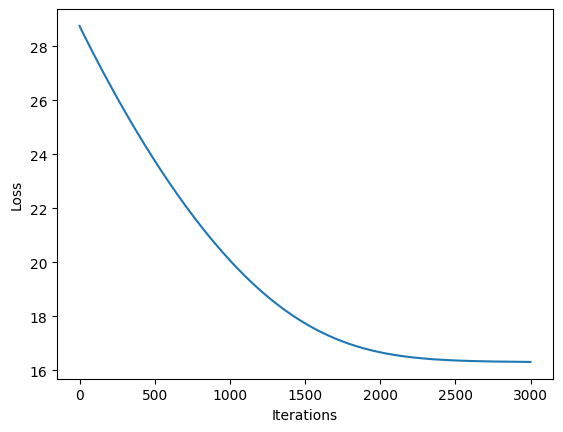

In [47]:
theta_star = MAP(x_train, y_train)
# posterior likelihood of test set using theta_star
post_log_likelihood = log_likelihood_y_theta(x_test, y_test, theta_star)

In [48]:
post_log_likelihood

tensor(-14.9268, dtype=torch.float64, grad_fn=<AddBackward0>)

i= 1
i= 2
i= 3
i= 4
i= 5
i= 6
i= 7
i= 8
i= 9
i= 10
i= 11
i= 12
i= 13
i= 14
i= 15
i= 16
i= 17
i= 18
i= 19
i= 20


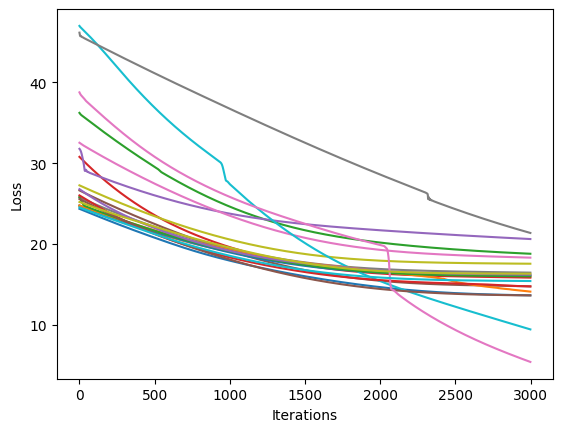

In [49]:
i = 1
post_log_likelihood = torch.zeros(20)
theta_stars = torch.zeros((20, 6))
while i <= 20:
  x, y = gen_data(l)
  np.random.seed(i)
  eval_indx = np.random.choice(l, 10, replace=False)
  x_test, y_test = x[eval_indx], y[eval_indx]
  x_train, y_train = np.delete(x, eval_indx), np.delete(y, eval_indx)
  try:
    theta_star = MAP(x_train, y_train)
  except:
    print("MAP failed")
    continue

  print("i=", i)
  post_log_likelihood[i-1] = log_likelihood_y_theta(x_test, y_test, theta_star).item()
  theta_stars[i-1] = theta_star

  i += 1

post_log_likelihood = np.array(post_log_likelihood)

In [50]:
print(post_log_likelihood)
print("Mean posterior log likelihood", post_log_likelihood.mean())
print("Std posterior log likelihood", post_log_likelihood.std())
best_theta = theta_stars[np.argmax(post_log_likelihood)]
print("Best theta", best_theta)

[-13.861373   -7.5905795 -14.03128   -17.045156   -9.291649  -16.917803
 -24.304667  -13.883144  -17.425304  -20.13241    -9.777219   -5.73176
  -7.7212644 -11.536473  -11.185374  -11.729841  -14.359767  -13.377297
  -8.231635  -12.997385 ]
Mean posterior log likelihood -13.056569
Std posterior log likelihood 4.46292
Best theta tensor([0.0903, 0.1961, 0.3596, 0.0176, 0.8738, 0.0101])


## NUTS sampling

In [52]:
input_dim = x_train.shape[0]

#cos_kernel = gp.kernels.Cosine(input_dim = input_dim)
periodic_kernel = gp.kernels.Periodic(input_dim = input_dim)
#prod_kernel = gp.kernels.Product(cos_kernel, cos_kernel)
poly2_kernel = gp.kernels.Polynomial(input_dim = input_dim, degree = 2)
poly4_kernel = gp.kernels.Polynomial(input_dim = input_dim, degree = 4)
sum_kernel_poly = gp.kernels.Sum(poly2_kernel, poly4_kernel)
sum_kernel = gp.kernels.Sum(periodic_kernel, sum_kernel_poly)
const_kernel = gp.kernels.Constant(input_dim = input_dim, variance = torch.Tensor([3/2]))

kernel = gp.kernels.Sum(sum_kernel, const_kernel)

# we pick a "high" variance according to Oswins notes page 16, "Weak priors"
# further we pick 0 as mean because we have very little data (also page 16, "complexity arguments")

periodic_kernel.variance = pyro.param(
    "variance_map",
    dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0)),  # samples initial value
    constraint=constraints.positive
)
#pyro.nn.PyroSample(dist.Normal(torch.tensor(0.0), torch.tensor(2.0))) # also try greater than 10^-4 gp lecture slide 52
# lognormal restricting it to positive values
periodic_kernel.lengthscale = pyro.param(
    "lengthscale_map",
    dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0)),  # samples initial value
    constraint=constraints.positive
)
periodic_kernel.period = pyro.param(
    "period_map",
    dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0)),  # samples initial value
    constraint=constraints.positive
)
poly2_kernel.variance = pyro.param(
    "variance_map",
    dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0)),  # samples initial value
    constraint=constraints.positive
)

poly4_kernel.variance = pyro.param(
    "variance_map",
    dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0)),  # samples initial value
    constraint=constraints.positive
)

gpr = gp.models.GPRegression(
                              X=torch.tensor(x_train),
                              y=torch.tensor(y_train),
                              kernel=kernel # noise=torch.tensor(0.1)
                            )

In [53]:
# Run HMC / NUTS
nuts_kernel = pyro.infer.NUTS(gpr.model, jit_compile=True)

mcmc= pyro.infer.MCMC(nuts_kernel, num_samples=2000, num_chains=4, warmup_steps=500)
mcmc.run()

/usr/local/lib/python3.11/dist-packages/pyro/infer/mcmc/api.py:499: UserWarning: num_chains=4 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(
Sample [3]: 100%|██████████| 2500/2500 [00:00, 12575.99it/s, step size=1.00e+00, acc. prob=1.000]


In [54]:
data = arviz.from_pyro(mcmc)

summary = arviz.summary(data)
print(summary)

arviz.plot_posterior(data)
plt.show()

           mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
diverging   0.0  0.0     0.0      0.0        0.0      0.0    8000.0    8000.0   

           r_hat  
diverging    NaN  


/usr/local/lib/python3.11/dist-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1357: UserWarning: Selecting first found group: sample_stats
  warnings.warn(f"Selecting first found group: {data.groups()[0]}")
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


ValueError: Can not extract posterior from Inference data with groups:
	> sample_stats
	> observed_data! See /usr/local/lib/python3.11/dist-packages/arviz/data/converters.py for other conversion utilities.

In [38]:
arviz.plot_trace(data, compact=False)
plt.show()

ValueError: Can not extract posterior from Inference data with groups:
	> sample_stats
	> observed_data! See /usr/local/lib/python3.11/dist-packages/arviz/data/converters.py for other conversion utilities.

## B.2

In [51]:
q_hat = [0, 5, 10]
l = 101
samples = 5
x, y = gen_data(l)
x = torch.tensor(x)

In [52]:
def compute_weights(n, l):
    w = torch.zeros(n)
    for i in range(n):
      if i < l:
        w[i] = 1/(2*l-2)
      else:
        w[i] = 1/(l-1)

    return w.double()

In [53]:
def get_kernel(theta, X):
    input_dim = 1#X.shape[0]
    pyro.clear_param_store()

    periodic_kernel = gp.kernels.Periodic(input_dim = input_dim)
    poly2_kernel = gp.kernels.Polynomial(input_dim = input_dim, degree = 2)
    poly4_kernel = gp.kernels.Polynomial(input_dim = input_dim, degree = 4)
    sum_kernel_poly = gp.kernels.Sum(poly2_kernel, poly4_kernel)
    sum_kernel = gp.kernels.Sum(periodic_kernel, sum_kernel_poly)
    const_kernel = gp.kernels.Constant(input_dim = input_dim, variance = torch.Tensor([3/2]))

    kernel = gp.kernels.Sum(sum_kernel, const_kernel)

    periodic_kernel.variance = theta[0]
    periodic_kernel.lengthscale = theta[1]
    periodic_kernel.period = theta[2]
    poly2_kernel.variance = theta[3]
    poly4_kernel.variance = theta[4]

    return kernel(X)

In [54]:
def mu_cov(w, K, q):
    # Compute mu
    mu = K @ w * (w.T @ K @ w) * q

    # Compute covariance
    print(K @ w)
    print(K @ w * (w.T @ K @ w))
    print((K @ w * (w.T @ K @ w)).unsqueeze(1) @ (K @ w).T.unsqueeze(0))
    cov = K - (K @ w * (w.T @ K @ w)).unsqueeze(1) @ (K @ w).T.unsqueeze(0)

    return mu, cov

In [55]:
for q in q_hat:
  print("q=", q)

  w = compute_weights(l, l)

  K = get_kernel(best_theta, x)
  print((K.transpose(0, 1) == K).all())

  mu, cov = mu_cov(w, K, q)
  print((cov.transpose(0, 1) == cov).all())
  print((cov.transpose(0, 1) == cov))
  print(cov)

  eigenvalues, eigenvectors = torch.linalg.eig(cov)
  # take positive eigenvalues
  A = eigenvectors @ torch.diag(torch.sqrt(eigenvalues))

  for j in range(samples):
      z = torch.randn(cov.shape[0])  # Standard normal samples
      f = mu + A @ z
      print(f)

q= 0
tensor(True)
tensor([1.2111, 1.2204, 1.2297, 1.2391, 1.2486, 1.2584, 1.2683, 1.2784, 1.2887,
        1.2993, 1.3100, 1.3209, 1.3321, 1.3434, 1.3550, 1.3668, 1.3788, 1.3910,
        1.4035, 1.4162, 1.4291, 1.4423, 1.4557, 1.4693, 1.4832, 1.4973, 1.5117,
        1.5262, 1.5408, 1.5555, 1.5706, 1.5862, 1.6022, 1.6184, 1.6350, 1.6521,
        1.6697, 1.6873, 1.7051, 1.7230, 1.7413, 1.7599, 1.7787, 1.7979, 1.8174,
        1.8372, 1.8573, 1.8777, 1.8985, 1.9196, 1.9410, 1.9628, 1.9849, 2.0074,
        2.0302, 2.0534, 2.0769, 2.1008, 2.1250, 2.1497, 2.1746, 2.2000, 2.2258,
        2.2518, 2.2780, 2.3045, 2.3315, 2.3591, 2.3872, 2.4158, 2.4448, 2.4745,
        2.5048, 2.5353, 2.5660, 2.5971, 2.6286, 2.6606, 2.6930, 2.7258, 2.7591,
        2.7929, 2.8272, 2.8619, 2.8971, 2.9327, 2.9689, 3.0055, 3.0426, 3.0803,
        3.1184, 3.1570, 3.1962, 3.2358, 3.2760, 3.3167, 3.3579, 3.3997, 3.4420,
        3.4847, 3.5278], dtype=torch.float64, grad_fn=<MvBackward0>)
tensor([1.2757, 1.2856, 1.2953, 1

RuntimeError: expected scalar type ComplexDouble but found Float